reference
- https://www.kaggle.com/code/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273/notebook
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [2]:
import os
import time
import random
import collections
import ast

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
TRAIN_CSV = "/home/jovyan/cellpose/masks_sub.csv"
TRAIN_PATH = "/mnt/external-images-pvc/david/liveCellPainting/raw_data/exp156/Images/"
MASKS_PATH = "/home/jovyan/cellpose/masks/"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of epochs
NUM_EPOCHS = 10

## Data loading

### Transform

In [4]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        image = F.convert_image_dtype(image) # added this line
        return image, target

def get_transform(train):
    transforms = [ToTensor()]    
    # Data augmentation for train
    #if train: 
    #    transforms.append(HorizontalFlip(0.5))
    #   transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

### Dataset

In [5]:
class CellDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, imgs_dir, masks_dir, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imgs_csv   = pd.read_csv(csv_file)
        self.masks_dir  = masks_dir
        self.images_dir = imgs_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name, mask_name = self.imgs_csv.iloc[idx, 0], self.imgs_csv.iloc[idx, 1]
        name = self.imgs_csv.iloc[idx,0]
        img = Image.open(self.images_dir + name + ".tiff")
        mask = Image.open(self.masks_dir  + name + "_mask.png")
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]       # remove 0(background)

        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.int8)
        image_id = torch.tensor([idx])
        if len(boxes) == 0:
            area = torch.zeros(1)
            boxes = torch.zeros(0, 4)
        else:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)               # assume all instances are not crowd

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [6]:
dataset = CellDataset(TRAIN_CSV, TRAIN_PATH, MASKS_PATH, get_transform(train=True))
trainloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=lambda x: tuple(zip(*x)))

## Model

In [7]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
model = get_model_instance_segmentation(num_classes=2)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_batches = len(trainloader)

## Training

In [85]:
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
    
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    
    for images, targets in trainloader:
        # Predict
        images = list(image.to(DEVICE) for image in images)
        for t in targets:
            for key, value in t.items():
                t[key] = t[key].to(device)

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
    
        lr_scheduler.step()
    
    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    
    
    elapsed = time.time() - time_start
    
    
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

torch.save(model, "model_MaskRCNN_10epochs")
torch.save(model.state_dict(), "model_MaskRCNN_10epochs.ckpt")

Starting epoch 1 of 10
[Epoch  1 / 10] Train mask-only loss:   0.352
[Epoch  1 / 10] Train loss:   1.827. [949 secs]
Starting epoch 2 of 10
[Epoch  2 / 10] Train mask-only loss:   0.351
[Epoch  2 / 10] Train loss:   1.821. [947 secs]
Starting epoch 3 of 10
[Epoch  3 / 10] Train mask-only loss:   0.351
[Epoch  3 / 10] Train loss:   1.821. [947 secs]
Starting epoch 4 of 10
[Epoch  4 / 10] Train mask-only loss:   0.351
[Epoch  4 / 10] Train loss:   1.821. [949 secs]
Starting epoch 5 of 10
[Epoch  5 / 10] Train mask-only loss:   0.351
[Epoch  5 / 10] Train loss:   1.821. [946 secs]
Starting epoch 6 of 10
[Epoch  6 / 10] Train mask-only loss:   0.351
[Epoch  6 / 10] Train loss:   1.822. [950 secs]
Starting epoch 7 of 10
[Epoch  7 / 10] Train mask-only loss:   0.351
[Epoch  7 / 10] Train loss:   1.821. [949 secs]
Starting epoch 8 of 10
[Epoch  8 / 10] Train mask-only loss:   0.351
[Epoch  8 / 10] Train loss:   1.821. [947 secs]
Starting epoch 9 of 10
[Epoch  9 / 10] Train mask-only loss:   0

## Evaluation

### Model state loading

In [11]:
model.load_state_dict(torch.load('model_MaskRCNN_10epochs.ckpt'))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
# Plots: the image, The image + the ground truth mask, The image + the predicted mask
def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.show()
    
    masks = np.zeros((1080, 1080))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Cellpose")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((1080, 1080))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > 0.7)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("MaskRCNN")
    plt.show()

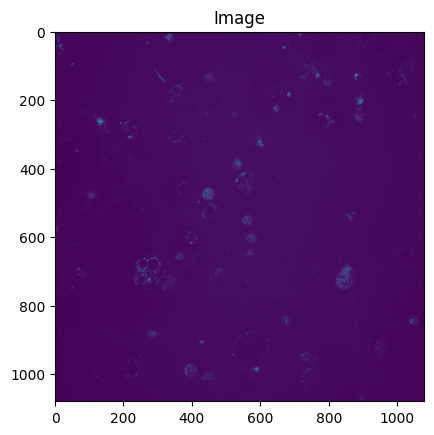

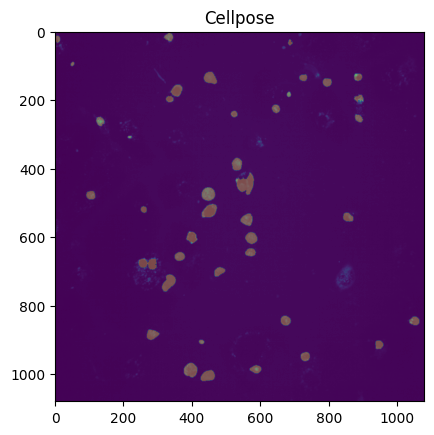

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


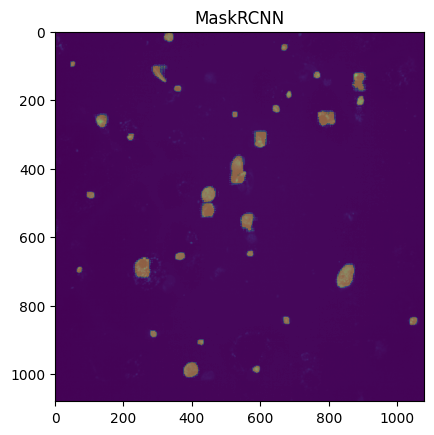

In [12]:
analyze_train_sample(model, dataset, 20)